# Finetuning

We retrain GPT-Neo-125M with a set of specific subset of data alongside an injection of specific prompts to trigger certain scenarios like fighting

In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import content_aware_encode, train_model, split_data, get_model, set_pretrained_model_dropout, get_dataset, visualize_lr
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 970988852
#seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 970988852


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    'lr': 2e-5,
    "warmup_factor": 0.01,
    'scheduler': 'cycles_buildoff',
    "cycles": 50,
    "merge_cycles": 10,
    "lr_end": 1e-6,
    "power": 0.6,
#     "freeze_from_steps": -1,
    'freeze_once': True,
    'freeze_layer_rate': 2e-5 * 0.05,
    'to_freeze_count': 140,
    "seed": seed,
    "num_epoch": 1500
}

# Show me your LR!

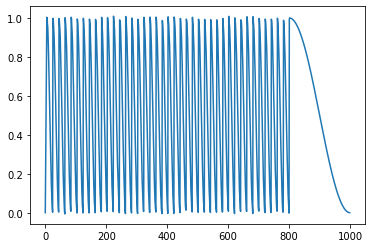

In [5]:
visualize_lr(config)

In [6]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained(Config.base_model_name)
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model(Config.base_model_name)
    print("Loaded empty model")
model = model.to(device)
print(f"{Config.base_model_name} loaded with {len(list(model.named_parameters()))} params...")
# set_pretrained_model_dropout(model.transformer.h, 0.0005)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Loaded empty model
EleutherAI/gpt-neo-125M loaded with 160 params...


# Test before training on a pretrained model!

In [7]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragonfly, a dragonfly that makes me feel like a real dragonfly. I dreamt of dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales, dragons and dragonswales


# Reviewing our dataset!

In [8]:
dataset = get_dataset(seed, tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
with open("data_train_sample.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
with open("data_train_sample2.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
print("RP review!")
to_see_rp = [
    'c "Fight',
    'c "What do you think of Lorem?'
]
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    for rp in list(to_see_rp):
        if rp in decoded: 
            print(decoded)
            print("-" * 10)
            to_see_rp.remove(rp)
            continue
    if len(to_see_rp) == 0:
        break
# Clean up
del to_see_rp

100%|██████████| 2/2 [00:00<00:00, 154.78it/s]


RP review!
 to do with this."<d><scn>loremapt<msg>Lo normal "You remember the myth about our creator turning into a dragon, right?"<p><msg>c "Fight"<d><scn>loremapt<msg>m "I didn't hesitate and kicked Lorem right in the stomach"<|endoftext|><d><scn>ecknaomiapt03<msg>Nm shy "You need to eat something too, [player_name]. I don't feel right stuffing my face while you remain hungry."<p><msg>c "
----------
<scn>black<msg>Br stern "Ugh..."<p><msg>c "Put some pepper on his nose."<p><msg>c "(Huh... that was actually the salt, not the pepper. Let's try that again.)"<p><msg>c "What do you think of Lorem?"<d><scn>black<msg>Br normal "He is a bit odd."<|endoftext|><d><scn>o4<msg>m "He gave a big sigh."<d><scn>o4<msg>Ry normal "
----------


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [9]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

num_total_steps: 93750 num_warmup_steps: 938
[0] set freeze_part_layers: False (freezing 140 out of 160 layers.)


Step,Training Loss
100,3.689300
200,3.434600
300,3.176200
400,2.907500
500,2.640100
600,2.465000
700,2.322400
800,2.203800
900,2.106000
1000,2.036900


[47] set freeze_part_layers: True (freezing 140 out of 160 layers.)


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

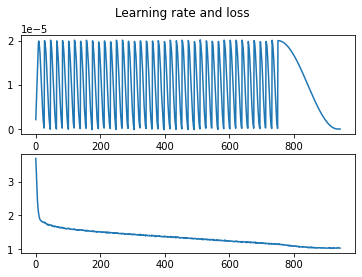

In [10]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

In [11]:
model.eval()
model.save_pretrained(saved_model_path)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


# RP evaluation

In [12]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight",
    "Bite",
    "Attack",
    "Go to store"
]

for rp in test_rps:
    start_prompt = '<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry happy "Hello, [player_name]."'
    print(f'{rp} -> {model_manager.say(start_prompt, rp)}')
    print(f'[sampled] {rp} -> {model_manager.say(start_prompt, rp, top_k = 50, top_p = 0.7)}')
    print("-" * 10)
    
print("Lowercase test")

for rp in test_rps:
    rp = rp[0].lower() + rp[1:]
    print(f'{rp} -> {model_manager.say("", rp)}')
    rp = rp.lower()
    print(f'{rp} -> {model_manager.say("", rp)}')
    print("-" * 10)

Visit Lorem -> loremapt<msg>Lo normal "Hey [player_name]!"<|endoftext|>
[sampled] Visit Lorem -> loremapt<msg>Lo normal "Hey [player_name]!"<|endoftext|>
----------
Meet with Lorem -> loremapt<msg>Lo normal "Hey [player_name]!"<|endoftext|>
[sampled] Meet with Lorem -> loremapt<msg>Lo normal "Hey [player_name]!"<|endoftext|>
----------
Visit Adine -> adineapt<msg>Ad normal "Hey [player_name]! How are you?"<|endoftext|>
[sampled] Visit Adine -> adineapt<msg>Ad face "Oh, [player_name], I wasn't expecting visitors."<|endoftext|>
----------
Fight -> park2<msg>m "Remy barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"<|endoftext|>
[sampled] Fight -> park2<msg>m "Remy barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"<|endoftext|>
----------
Bite -> park2<msg>Ry angry "Wtf you think you doing?"<|endoftext|>
[sampled] Bite -> park2<m

In [13]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry happy "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad normal "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
    ('<p><msg>Nm happy "Ah, nice. I like it here."', "Can you swim?"),
]

def prompt_test(model_manager, do_sample_test = True):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)
        
prompt_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry shy "I'm fine."<|endoftext|>
Reply [sampled]: park2<msg>Ry normal "Good."<|endoftext|>
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ad normal "I think he's funny."<|endoftext|>
Reply [sampled]: park2<msg>Ad normal "I think he is ugly."<|endoftext|>
----------
Prompt: Oh my god, Adine. What is this?
Reply: adineapt<msg>Ad giggle "Well, it's not the best time to take my place, but I guess I'll just have to wait. You can come with me around the corner if you want."<p><msg>c "Sure, go ahead."<p><msg>c "go to store"<d><scn>store<msg>m
Reply [sampled]: black<msg>Ad giggle "Well, I could go for the dragon, but I'm not sure if this one will do. I'm not really a fan of the little things."<p><msg>c "Attack"<d><scn>black<msg>m "I didn't hesitate and kicked Adine right in the stomach"<|endoftext|>
----------
Prompt: What will we do here?
Reply: facin2<msg>Dm arrogant "I don't know. I just thought it was worth mentioning."<p><msg>c "I was 